# Simulation of observed spectrum

- author : Sylvie Dagoret-Campagne
- date jun 19th 2017

In [3]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [4]:
print(theNotebook)

GenerateSimulationProfiles


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
from astropy.table import Table, Column
import re
import os

In [6]:
import pandas as pd

In [7]:
from matplotlib.backends.backend_pdf import PdfPages

### Import libradtan tools for simulation

In [8]:
import sys
sys.path.append('../../spectrumsim/libradtransim')

In [9]:
from libsimulateTranspCTIOScattAbs import *

In [10]:
sys.path.append('../../spectrumsim')
import libCTIOTransm as ctiosim 

### import pysynphot tools for CALSPEC SED

In [11]:
os.environ['PYSYN_CDBS']

'/Users/dagoret-campagnesylvie/MacOsX/External/PySyn_CDBS/grp/hst/cdbs'

In [12]:
import pysynphot as S
from astropy.io import ascii

### CTIO Properties

In [13]:
path_ctiodata='../../spectrumsim/CTIOThroughput'
qe_filename='qecurve.txt'

### esthetic

In [14]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [15]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

In [16]:
def truncate(f, n):
    '''Truncates/pads a float f to n decimal places without rounding'''
    s = '{}'.format(f)
    if 'e' in s or 'E' in s:
        return '{0:.{1}f}'.format(f, n)
    i, p, d = s.partition('.')
    return '.'.join([i, (d+'0'*n)[:n]])

In [17]:
infos='ctio31may2017'

In [18]:
rootpath_rawimage="../OverScanRemove/trim_images"
MIN_IMGNUMBER=141
MAX_IMGNUMBER=175
object_name='HD205905_May_31th'
SelectTagRe='^trim_20170531_([0-9]+).fits$' # regular expression to select the file
SearchTagRe='^trim_20170531_[0-9]+.fits$'
NBIMGPERLROW=4
calspec_sed='hd205905_stis_003.fits'

In [19]:
logfile='logbk_'+object_name+'_'+infos+'.fits'
pandaslogfile='logbk_'+object_name+'_'+infos+'.csv'

In [20]:
outputfitsfile='AllSimSpectra_'+object_name+'.fits'

In [21]:
dir_top_images="images_notebooks/"+theNotebook ### Top directory to save images

In [22]:
ensure_dir(dir_top_images)

## Get list of airmass

In [23]:
df=pd.read_csv(pandaslogfile)

In [24]:
df.head()

,Unnamed: 0,number,airmass,date,filename,exposure,zenith,temperature,pressure,humidity,windspeed,seeing,filter1,filter2
0,0,143,1.116,2017-06-01T07:43:16.395,../OverScanRemove/trim_images/,120.0,26.333000,11.5,780.0,22.0,21.299999,1.000,RG715,Ron400
1,1,144,1.110,2017-06-01T07:46:08.899,../OverScanRemove/trim_images/,120.0,25.709000,11.1,780.0,22.0,19.200001,1.071,RG715,Thor300
2,2,145,1.104,2017-06-01T07:49:01.406,../OverScanRemove/trim_images/,120.0,25.086000,11.7,780.0,21.0,22.299999,1.232,RG715,HoloPhP
3,3,146,1.098,2017-06-01T07:51:53.907,../OverScanRemove/trim_images/,240.0,24.464001,11.5,780.0,21.0,22.799999,1.189,RG715,HoloPhAg
4,4,147,1.090,2017-06-01T07:56:46.406,../OverScanRemove/trim_images/,240.0,23.407000,11.9,780.0,21.0,25.299999,1.106,RG715,HoloAmAg


In [25]:
airmasses=df["airmass"]
date=df['date']
expo=df['exposure']
datafile=df['filename']
temperature=df['temperature']
pressure=df['pressure']
humidity=df['humidity']
seeing=df['seeing']
disperser=df['filter2']

## Get quantum efficiency

In [26]:
wl_qe,tr_qe=ctiosim. Get_QE()

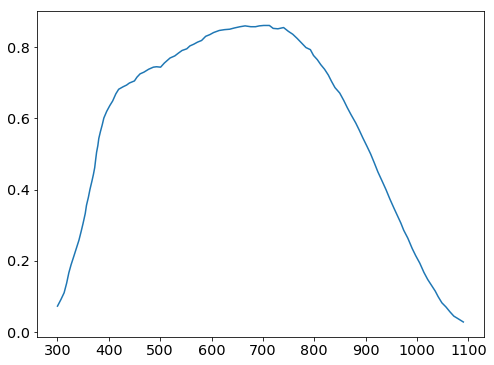

In [27]:
plt.plot(wl_qe,tr_qe)

In [28]:
bp_ctio_qe = S.ArrayBandpass(wl_qe*10.,tr_qe, name='CTIO QE')

## Get mirror

In [29]:
wl_m,tr_m=ctiosim. Get_Mirror()

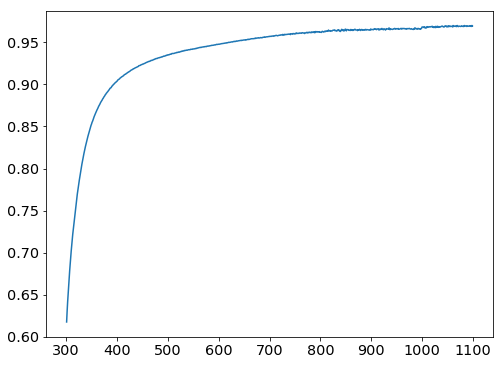

In [30]:
plt.plot(wl_m,tr_m)

In [31]:
bp_ctio_m = S.ArrayBandpass(wl_m*10.,tr_m*tr_m, name='CTIO Mirror2')  # two mirrors

### Get Filter

In [32]:
wl_f,tr_f=ctiosim. Get_RG175()

In [33]:
bp_ctio_f = S.ArrayBandpass(wl_f*10.,tr_f, name='RG175')  # two mirrors

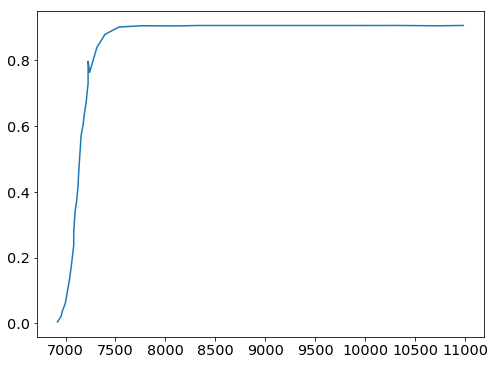

In [34]:
plt.plot(bp_ctio_f.wave,bp_ctio_f.throughput)

### Combine

In [35]:
bp_ctio=bp_ctio_qe*bp_ctio_m*bp_ctio_f

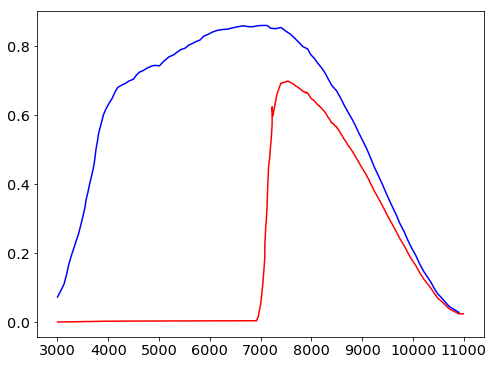

In [36]:
plt.plot(bp_ctio.wave,bp_ctio.throughput,'r-')
plt.plot(wl_qe*10,tr_qe,'b-')

## Get SED from CALSPEC 

- using Pysynphot

In [37]:
CTIO_COLL_SURF=0.9*(u.m)**2/(u.cm)**2  # LSST collectif surface
WLMIN=3000.
WLMAX=11000.

In [38]:
S.refs.setref(area=CTIO_COLL_SURF.decompose(), waveset=None)
S.refs.set_default_waveset(minwave=WLMIN, maxwave=WLMAX, delta=10, log=False)

In [39]:
filename = os.path.join(os.environ['PYSYN_CDBS'], 'calspec',calspec_sed)
sed = S.FileSpectrum(filename)

Warning, 6 of 3739 bins contained negative fluxes; they have been set to zero.


In [40]:
with fits.open(filename) as pf:
    print(pf[1].header)

XTENSION= 'BINTABLE'           /Written by IDL:  Wed Dec 24 09:04:47 2014       BITPIX  =                    8 /                                                NAXIS   =                    2 /Binary table                                    NAXIS1  =                   30 /Number of bytes per row                         NAXIS2  =                 3739 /Number of rows                                  PCOUNT  =                    0 /Random parameter count                          GCOUNT  =                    1 /Group count                                     TFIELDS =                    7 /Number of columns                               EXTNAME = 'SCI     '           /                                                EXTVER  =                    1 /                                                INHERIT =                    T /                                                TFORM1  = '1D      '           /Real*8 (double precision)                       TTYPE1  = 'WAVELENGTH'         /Label fo

# Simulate atmosphere

In [41]:
all_wl_atm= []
all_tr_atm= []
all_bp_atm = []
PWV=4.
OZ=300.

In [42]:
for index,am in np.ndenumerate(airmasses):
    idx=index[0]
    path,file=ProcessSimulation(am,PWV,OZ)   
    fullfilename=os.path.join(path,file)
    atm_data=np.loadtxt(fullfilename)
    wl_atm=atm_data[:,0]
    tr_atm=atm_data[:,1]
    all_wl_atm.append(wl_atm)
    all_tr_atm.append(tr_atm)
    atm_filter_name='CTIO atm {}'.format(idx)
    bp_atm = S.ArrayBandpass(wl_atm*10.,tr_atm, name=atm_filter_name)  # Pysynphot pass band
    all_bp_atm.append(bp_atm) 

--------------------------------------------
 2) airmass =  1.11600005627
 2) pwv =  4.0
 2) oz =  300.0
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/CT/pp/us/sa/rt/in/RT_CT_pp_us_sa_rt_z11_wv40_oz30.INP')
('Output to file                : ', 'simulations/RT/2.0.1/CT/pp/us/sa/rt/out/RT_CT_pp_us_sa_rt_z11_wv40_oz30.OUT')
('uvspec cmd: ', '/Users/dagoret-campagnesylvie/MacOsX/LSST/softs/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/CT/pp/us/sa/rt/in/RT_CT_pp_us_sa_rt_z11_wv40_oz30.INP > simulations/RT/2.0.1/CT/pp/us/sa/rt/out/RT_CT_pp_us_sa_rt_z11_wv40_oz30.OUT')
--------------------------------------------
 2) airmass =  1.11000001431
 2) pwv =  4.0
 2) oz =  300.0
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/CT/pp/us/sa/rt/in/RT_CT_pp_us_sa_rt_z11_wv40_oz30.INP')
('Output to file                : ', 'simulations/RT/2.0.1/CT/pp/us/sa/rt/out/RT_CT_pp_us_sa_rt_z11_wv

## Observed spectra

- calculate the observed spectra and save it in list

In [43]:
all_obs_spectra = []
all_obs_wl= []
all_obs_fluxes = []

for index,am in np.ndenumerate(airmasses):
    idx=index[0]
    atm_filter_name='CTIO atm {}'.format(idx)
    the_bp_atm=bp_atm = S.ArrayBandpass(all_wl_atm[idx]*10.,all_tr_atm[idx], name=atm_filter_name)  # Pysynphot pass band
    bp_ctio_atm = bp_ctio*the_bp_atm # Multply atm tansmission by CCD QE efficiciency
    bp_ctio_atm.binning=10.
    obs_ctio = S.Observation(sed,bp_ctio_atm)
    all_obs_spectra.append(obs_ctio)
    all_obs_wl.append(obs_ctio.wave)
    all_obs_fluxes.append(obs_ctio.flux) 
    


((((CTIO QE * CTIO Mirror2) * RG175) * CTIO atm 0)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((((CTIO QE * CTIO Mirror2) * RG175) * CTIO atm 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((((CTIO QE * CTIO Mirror2) * RG175) * CTIO atm 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((((CTIO QE * CTIO Mirror2) * RG175) * CTIO atm 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((((CTIO QE * CTIO Mirror2) * RG175) * CTIO atm 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((((CTIO QE * CTIO Mirror2) * RG175) * CTIO atm 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((((CTIO QE * CTIO Mirror2) * RG175) * CTIO atm 6)) does not have a de

(0, 10000)

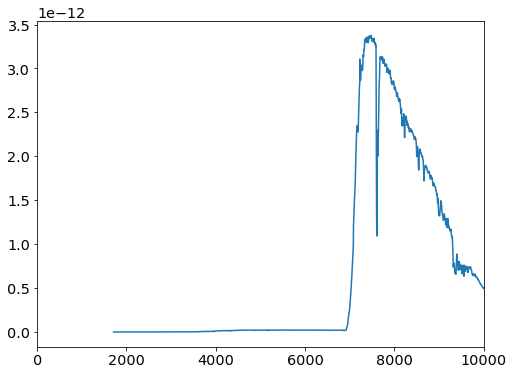

In [44]:
plt.plot(all_obs_wl[0], all_obs_fluxes[0])
plt.xlim(0,10000)

In [45]:
def MakeSimNpArray(all_simwavelength,all_simspectra):
    
    all_simspectra=np.array(all_simspectra)
    simwavelength=np.array(all_simwavelength[0])
    
    NBSPEC=all_simspectra.shape[0]
    NBWL=simwavelength.shape[0]
    
    print NBSPEC,' , ',NBWL
    dataout=np.zeros((NBSPEC+1,NBWL))
    
    dataout[0,:]=simwavelength
    
    for ispec in np.arange(1,NBSPEC+1):
        dataout[ispec,:]=all_simspectra[ispec-1]
    return dataout

In [46]:
spectra_out=MakeSimNpArray(all_obs_wl,all_obs_fluxes)

33  ,  4839


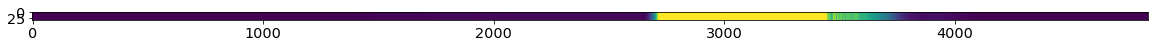

In [47]:
plt.figure(figsize=(20,20))
plt.imshow(spectra_out[:,:],vmin=0,vmax=1e-12)

In [48]:
def CompareSpectrumProfile(allspectra,object_name,dir_top_img):
    """
    CompareSpectrumProfile
    =====================
    
    """
    shortfilename='CompareSimSpec_'+object_name+'.pdf'
    title="Compare simulated spectra of {}".format(object_name)
    figfilename=os.path.join(dir_top_img,shortfilename)
    pp = PdfPages(figfilename) # create a pdf file
    
    
    f, axarr = plt.subplots(1,1,figsize=(25,15))
    f.suptitle(title,size=20)
    
    NBSPEC=allspectra.shape[0]-1
    wl=allspectra[0]
    
    
    min_z=truncate(min(airmasses),2)
    max_z=truncate(max(airmasses),2)
    
    maxim_y_to_plot= []

    texte='airmass : {} - {} '.format(min_z,max_z)
    
    for index in np.arange(0,NBSPEC):
                
       
        axarr.plot(wl,allspectra[index+1],'-')
        maxim_y_to_plot.append(allspectra[index+1].max())
    
    max_y_to_plot=max(maxim_y_to_plot)
    axarr.set_ylim(0,max_y_to_plot)
    axarr.text(0.,max_y_to_plot*0.9, texte ,verticalalignment='top', horizontalalignment='left',color='blue',fontweight='bold', fontsize=20)
    axarr.grid(True)
    axarr.set_xlim(0,12000)
    
    axarr.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    axarr.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    axarr.grid(b=True, which='major', color='k', linewidth=2.0)
    axarr.grid(b=True, which='minor', color='grey', linewidth=0.5)
    
    
    
    axarr.set_xlabel("wavelength (A)")
    
        
    f.savefig(pp, format='pdf')
    f.show()
    
    pp.close()     
    

/Users/dagoret-campagnesylvie/anaconda/envs/pyastrophys/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


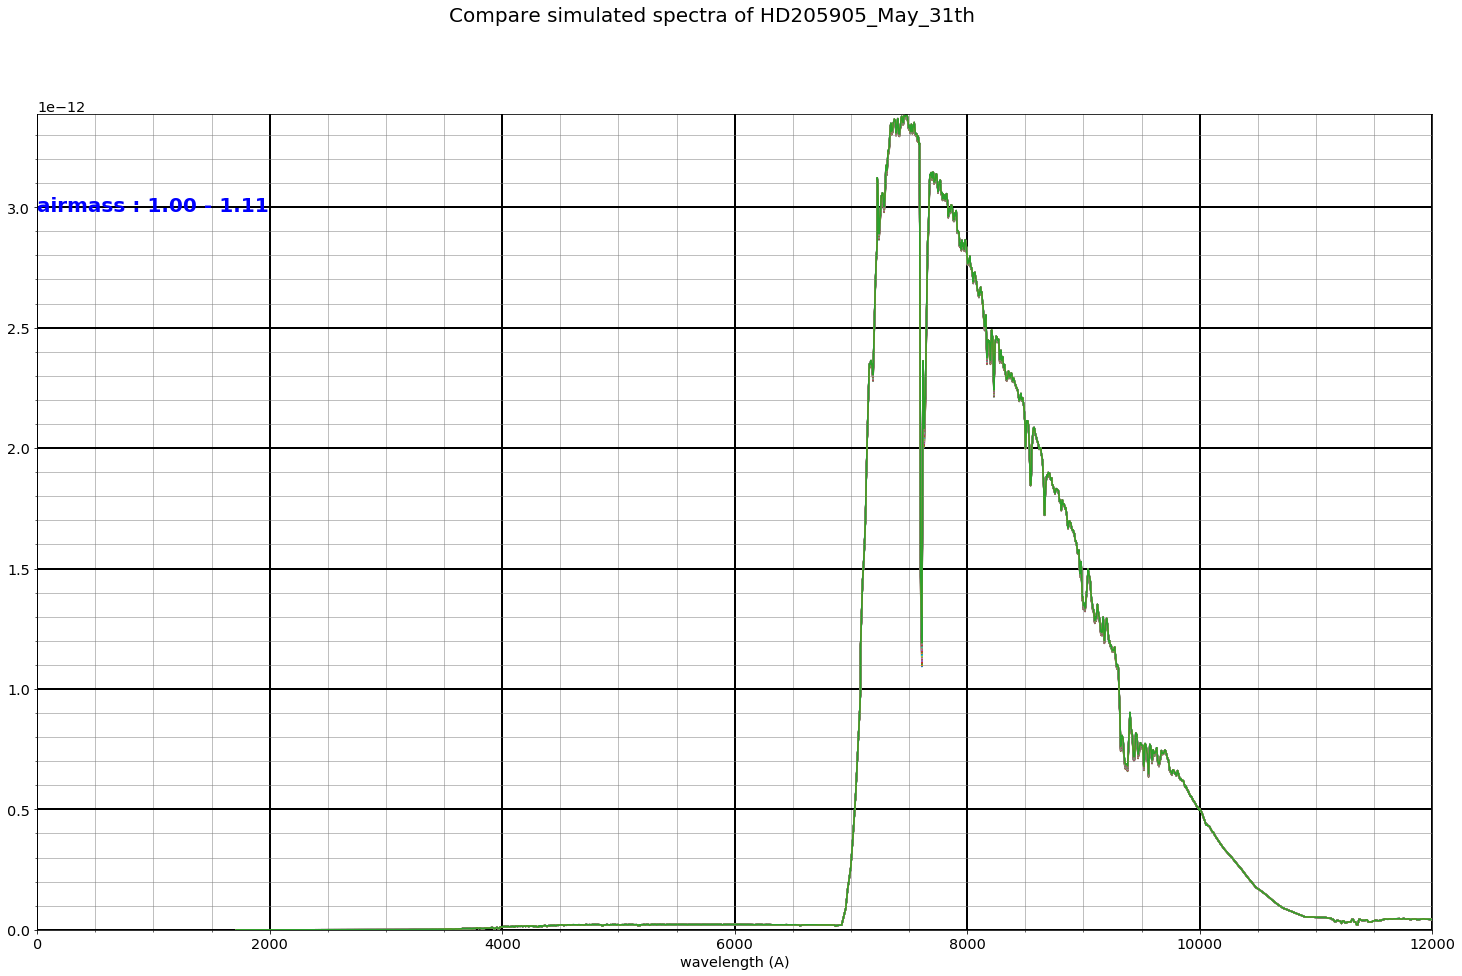

In [49]:
CompareSpectrumProfile(spectra_out,object_name,dir_top_images)

## Save output file

In [50]:
prihdu = fits.PrimaryHDU(data=spectra_out)
thdulist = fits.HDUList(prihdu)
thdulist.writeto(outputfitsfile,overwrite=True)

In [51]:
spectra_out.shape

(34, 4839)